## Introduction/Business Problem

When a municipality wants to know and better serve its citizens, there are many ways to do so. One of them is a survey, which involves going door to door to meet people and asking them a few prepared questions to better understand their feelings about safety, services offered by the municipality or surrounding businesses. Following this type of survey, it is necessary to define which categories of people feel the most left out in order to better target the services to be provided to the greatest number of people, and to adopt a policy accordingly.

As such, the City of Montreal conducted this type of survey in 2016. In this survey, more than 7,000 people were questioned and we are especially interested in their satisfaction with the businesses and services offered in their borough.

The final objective will be to have a recommendation of services and businesses to develop for the groups who feel the most left out by borough.

## Data

To proceed with this analysis, we will need to retrieve the data from the survey conducted by the City of Montreal (https://donnees.montreal.ca/ville-de-montreal/sondage-satisfaction-citoyens). These data will allow us to create several people clusters based on their profile (age category, number of years of study, mother tongue, etc.), their neighbourhood of residence and their level of satisfaction with the services and shops in their borough. 

From the API foursquare, we will retrieve the list of services, stores and leisure activities in the borough.

## Analysis

### Scraping and cleansing satisfaction survey

In [1]:
import pandas as pd
import requests

web_url = 'https://data.montreal.ca/dataset/4656e09e-001d-4ad3-95de-67235310ecb7/resource/998f72da-3819-4058-9e24-5df42d2197ad/download/resultatssondagesatisfactioncollectifs2016.csv'
local_url = 'resultatssondagesatisfactioncollectifs2016.csv' 
# df_survey_init = pd.read_csv(web_url)
# df_survey_init.to_csv(local_url)

df_survey_init = pd.read_csv(local_url)
df_survey_init.head()

/home/oleptsep/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (97) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,PrjName,RecordNo,Q2,Q3,Q33,Q4A,Q4C,Q4D,Q4E,Q4F,...,Q34O,Q35,Q36,Q36B,Q36BO,Q36C,Q36CO,Q37,LANG,POND
0,12000_112A,7,H1K,2,3,1,3,3,2,3,...,NaN,1,4,1,NaN,1,NaN,1,FR,"0,396711"
1,12000_112A,19,H2M,1,6,2,2,2,1,1,...,NaN,1,2,3,NaN,2,NaN,2,FR,"3,506344"
2,12000_112A,24,H2V,11,2,2,2,2,2,2,...,NaN,2,2,1,NaN,1,NaN,1,FR,"6,494073"
3,12000_112A,27,H1K,2,4,2,2,4,2,2,...,NaN,2,4,1,NaN,1,NaN,1,FR,"0,300058"
4,12000_112A,33,H1F,15,2,1,1,1,1,1,...,NaN,9,9,99,NaN,1,NaN,1,FR,"1,746619"


In [2]:
# Keep only the following columns related to the respondent (Q2, Q3, Q33, Q34, Q35, Q36, Q36B, Q36C, Q37)
# and their level of satisfaction with the services and shops in their neighborhood (Q8A)
df_survey = df_survey_init[['Q2', 'Q33', 'Q34','Q35', 'Q36', 'Q36B', 'Q37', 'Q8A']]
df_survey.head()

,Q2,Q33,Q34,Q35,Q36,Q36B,Q37,Q8A
0,H1K,3,2,1,4,1,1,3
1,H2M,6,4,1,2,3,2,1
2,H2V,2,5,2,2,1,1,2
3,H1K,4,2,2,4,1,1,1
4,H1F,2,9,9,9,99,1,1


In [3]:
# rename column title to significant title
df_survey.columns = ['PostalCode', 'age_group', 'household_type', 'owner_tenant', 'education_level', 'occupation', 'sex', 'satisfaction_result']
df_survey.head()

,PostalCode,age_group,household_type,owner_tenant,education_level,occupation,sex,satisfaction_result
0,H1K,3,2,1,4,1,1,3
1,H2M,6,4,1,2,3,2,1
2,H2V,2,5,2,2,1,1,2
3,H1K,4,2,2,4,1,1,1
4,H1F,2,9,9,9,99,1,1


In [4]:
df_survey.dtypes

PostalCode             object
age_group               int64
household_type          int64
owner_tenant            int64
education_level         int64
occupation              int64
sex                     int64
satisfaction_result     int64
dtype: object

REMOVE PEOPLE THAT DID NOT RESPOND TO THIS SURVEY QUESTION

In [5]:
print('shapes prior removing non-response of satisfaction survey', df_survey.shape)
# non-response = 9
df_survey = df_survey[df_survey.satisfaction_result != 9]
print('shapes after removing non-response of satisfaction survey', df_survey.shape)

shapes prior removing non-response of satisfaction survey (7614, 8)
shapes after removing non-response of satisfaction survey (7564, 8)


CLEANSING ZIP CODE

In [6]:
# since we will use the PostalCode to locate each people, we need to ensure that we keed only valid Montreal PostalCode based on https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_H
valid_PostalCode = ['H0M',
                'H1A', 'H1B', 'H1C', 'H1E', 'H1G', 'H1H', 'H1J', 'H1K', 'H1L', 'H1M', 'H1N', 'H1P', 'H1R', 'H1S', 'H1T', 'H1V', 'H1W', 'H1X', 'H1Y', 'H1Z', 
                'H2A', 'H2B', 'H2C', 'H2E', 'H2G', 'H2H', 'H2J', 'H2K', 'H2L', 'H2M', 'H2N', 'H2P', 'H2R', 'H2S', 'H2T', 'H2V', 'H2W', 'H2X', 'H2Y', 'H2Z',
                'H3A', 'H3B', 'H3C', 'H3E', 'H3G', 'H3H', 'H3J', 'H3K', 'H3L', 'H3M', 'H3N', 'H3P', 'H3R', 'H3S', 'H3T', 'H3V', 'H3W', 'H3X', 'H3Y', 'H3Z',
                'H4A', 'H4B', 'H4C', 'H4E', 'H4G', 'H4H', 'H4J', 'H4K', 'H4L', 'H4M', 'H4N', 'H4P', 'H4R', 'H4S', 'H4T', 'H4V', 'H4W', 'H4X', 'H4Y', 'H4Z',
                'H5A', 'H5B',
                'H7A', 'H7B', 'H7C', 'H7E', 'H7G', 'H7H', 'H7J', 'H7K', 'H7L', 'H7M', 'H7N', 'H7P', 'H7R', 'H7S', 'H7T', 'H7V', 'H7W', 'H7X', 'H7Y',
                'H8N', 'H8P', 'H8R', 'H8S', 'H8T', 'H8Y', 'H8Z',
                'H9A', 'H9B', 'H9C', 'H9E', 'H9G', 'H9H', 'H9J', 'H9K', 'H9P', 'H9R', 'H9S', 'H9W', 'H9X']
all_PostalCode = df_survey['PostalCode'].unique()
invalid_PostalCode = []
for i in all_PostalCode:
    if not i in valid_PostalCode:
        invalid_PostalCode.append(i)

In [7]:
# FOR CLEANSING, remove all ZIP Code that are in invalid_PostalCode
for i in invalid_PostalCode:
    df_survey = df_survey[df_survey.PostalCode != i]
    print('shapes after removing {}: {}'.format(i, df_survey.shape))

shapes after removing H1F: (7554, 8)
shapes after removing 999: (7106, 8)
shapes after removing H2D: (7105, 8)
shapes after removing H8C: (7095, 8)
shapes after removing H8M: (7085, 8)
shapes after removing H8F: (7060, 8)
shapes after removing H1D: (7059, 8)
shapes after removing H8B: (7053, 8)
shapes after removing H9Z: (7051, 8)
shapes after removing A9A: (7050, 8)
shapes after removing H2F: (7043, 8)
shapes after removing H9T: (7040, 8)
shapes after removing H8V: (7039, 8)
shapes after removing J7V: (7037, 8)
shapes after removing H4F: (7035, 8)
shapes after removing V2V: (7034, 8)
shapes after removing G0R: (7033, 8)
shapes after removing J3I: (7032, 8)
shapes after removing H3F: (7025, 8)
shapes after removing H3O: (7024, 8)
shapes after removing H0H: (7023, 8)
shapes after removing H8X: (7022, 8)
shapes after removing H5R: (7021, 8)
shapes after removing H4D: (7019, 8)
shapes after removing H8Q: (7017, 8)
shapes after removing H2I: (7016, 8)
shapes after removing H8L: (7014, 8)
s

CLEANSING CATEGORIES OF RESPONDANT

for most of questions about respondant profile, the response '9' means No Answer or Do not Know. So we will eliminate these rows, when they contain at least one '9' and check how many responses are removed.

In [8]:
print(df_survey['age_group'].unique())
df_survey = df_survey[df_survey.age_group != 9]
df_survey.shape

[3 6 2 4 5 1]


(6993, 8)

In [9]:
print(df_survey['household_type'].unique())
df_survey = df_survey[df_survey.household_type != 9]
df_survey.shape

[2 4 5 1 3 9]


(6933, 8)

In [10]:
print(df_survey['owner_tenant'].unique())
df_survey = df_survey[df_survey.owner_tenant != 9]
df_survey.shape

[1 2 9]


(6918, 8)

In [11]:
print(df_survey['education_level'].unique())
df_survey = df_survey[df_survey.education_level != 9]
df_survey.shape

[4 2 1 3 9]


(6881, 8)

In [12]:
print(df_survey['occupation'].unique())
df_survey = df_survey[df_survey.occupation != 99]
df_survey.shape

[ 1  3  2  6  5  8  4 99  7]


(6871, 8)

so, after cleansing, we reduced the sample by ~10%

### Get the foursquare results around each PostalCode

In [13]:
df_geo = pd.read_csv('H_postalcode_lat_long.csv')
df_geo.columns = ['PostalCode', 'Latitude', 'Longitude']

df_geo

,PostalCode,Latitude,Longitude
0,H1A,45.676258,-73.521059
1,H1B,45.642434,-73.509856
2,H1C,45.671153,-73.558388
3,H1E,45.635664,-73.604164
4,H1G,45.607280,-73.638533
...,...,...,...
116,H9P,45.472258,-73.768480
117,H9R,45.458894,-73.830889
118,H9S,45.437500,-73.813602
119,H9W,45.430848,-73.882756


In [14]:
CLIENT_ID = 'id' # your Foursquare ID
CLIENT_SECRET = 'secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: id
CLIENT_SECRET:secret


In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=3000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'PostalCode Latitude', 
                  'PostalCode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
foursquare_results_file = 'h_3000_results.csv'

h_venues = pd.read_csv(foursquare_results_file)

# keep only PostalCode and VenueCategory
pd_venues = h_venues[['PostalCode', 'Venue Category']]
pd_venues

,PostalCode,Venue Category
0,H1A,Golf Course
1,H1A,Park
2,H1A,Breakfast Spot
3,H1A,Grocery Store
4,H1A,Restaurant
...,...,...
9609,H9X,Italian Restaurant
9610,H9X,Bar
9611,H9X,Thai Restaurant
9612,H9X,Convenience Store


In [17]:
# Group occurence of Venue Category per PostalCode
# one hot encoding
pd_onehot = pd.get_dummies(pd_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
pd_onehot['PostalCode'] = pd_venues['PostalCode'] 

# move neighborhood column to the first column
fixed_columns = [pd_onehot.columns[-1]] + list(pd_onehot.columns[:-1])
pd_onehot = pd_onehot[fixed_columns]

pd_onehot.head()

,PostalCode,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Transportation Service,Tunnel,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Women's Store,Yoga Studio,Zoo
0,H1A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,H1A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,H1A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,H1A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,H1A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
pd_grouped = pd_onehot.groupby('PostalCode').mean().reset_index()
pd_grouped.head()

,PostalCode,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Transportation Service,Tunnel,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Women's Store,Yoga Studio,Zoo
0,H1A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,H1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,H1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,H1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0
4,H1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.014493,0.0,0.0,0.0,0.0,0.0


In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:
import numpy as np
num_top_venues = 10

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    columns.append('MostCommonVenue{}'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['PostalCode'] = pd_grouped['PostalCode']

for ind in np.arange(pd_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(pd_grouped.iloc[ind, :], num_top_venues)

venues_sorted

,PostalCode,MostCommonVenue1,MostCommonVenue2,MostCommonVenue3,MostCommonVenue4,MostCommonVenue5,MostCommonVenue6,MostCommonVenue7,MostCommonVenue8,MostCommonVenue9,MostCommonVenue10
0,H1A,Restaurant,Italian Restaurant,Grocery Store,Gas Station,Convenience Store,Pharmacy,Park,Auto Dealership,Thai Restaurant,Shopping Mall
1,H1B,Restaurant,Gas Station,Coffee Shop,Pharmacy,Supermarket,Grocery Store,Fast Food Restaurant,Breakfast Spot,Auto Dealership,Liquor Store
2,H1C,Pharmacy,Grocery Store,Convenience Store,Liquor Store,Pizza Place,Fast Food Restaurant,Hardware Store,Baseball Field,Bakery,Theater
3,H1E,Pharmacy,Coffee Shop,Grocery Store,Italian Restaurant,Liquor Store,Restaurant,Fast Food Restaurant,Gas Station,Pizza Place,Recreation Center
4,H1G,Pharmacy,Fast Food Restaurant,Supermarket,Gas Station,Coffee Shop,Breakfast Spot,Restaurant,Liquor Store,Sandwich Place,Grocery Store
...,...,...,...,...,...,...,...,...,...,...,...
116,H9P,Coffee Shop,Restaurant,Fast Food Restaurant,Sushi Restaurant,Breakfast Spot,Airport Service,Airport Lounge,Italian Restaurant,Gym,Hotel
117,H9R,Coffee Shop,Italian Restaurant,Liquor Store,Fast Food Restaurant,Pharmacy,Bank,Pizza Place,Grocery Store,Breakfast Spot,Restaurant
118,H9S,Bank,Coffee Shop,Liquor Store,Ice Cream Shop,Shopping Mall,Bakery,Harbor / Marina,Pub,Pool,Sushi Restaurant
119,H9W,Coffee Shop,Italian Restaurant,Gas Station,Fast Food Restaurant,Pharmacy,Bank,Liquor Store,Sandwich Place,Bistro,Restaurant


## Clustering survey respondants based on their characteristics

In [21]:
df_survey.head()

,PostalCode,age_group,household_type,owner_tenant,education_level,occupation,sex,satisfaction_result
0,H1K,3,2,1,4,1,1,3
1,H2M,6,4,1,2,3,2,1
2,H2V,2,5,2,2,1,1,2
3,H1K,4,2,2,4,1,1,1
5,H1E,6,2,1,2,2,1,1


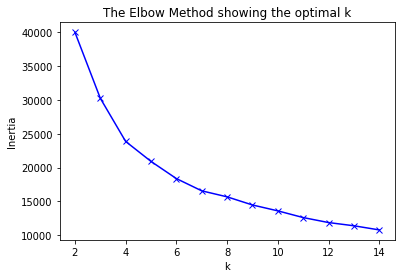

In [22]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import numpy as np

df_survey_clustering = df_survey
df_survey_clustering = df_survey_clustering.drop('PostalCode', 1).drop('satisfaction_result',1)

inertia=[]
# set number of clusters
k_range = range(2,15)
for i in k_range:
   # run k-means clustering
    kmeans = KMeans(n_clusters=i, random_state=0).fit(df_survey_clustering)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [23]:
# compute to cluster in 4 different groups
kmeans = KMeans(n_clusters=4, random_state=0).fit(df_survey_clustering)
# add clustering labels
df_survey.insert(0, 'cluster_labels', kmeans.labels_)
df_survey.head()

,cluster_labels,PostalCode,age_group,household_type,owner_tenant,education_level,occupation,sex,satisfaction_result
0,1,H1K,3,2,1,4,1,1,3
1,0,H2M,6,4,1,2,3,2,1
2,1,H2V,2,5,2,2,1,1,2
3,1,H1K,4,2,2,4,1,1,1
5,2,H1E,6,2,1,2,2,1,1


In [24]:
df_survey.to_csv('tmp_survey.csv')

## Determine the less satisfied cluster  and most satisfied clusters of each PostalCode

In [25]:
# GET THE NUMBER OF RESPONDANTS PER PostalCode in order to determine which PostalCode can be removed due to lack of a too small sample of respondants (less than 25 respondants per PostalCode and less than 5 respondants per)
# since we have around 7000 respondants divided into 100 PostalCode
# 70 respondants per PostalCode is the average
# 10 respondants per clusters per PostalCode is the average
df_resp = df_survey[['PostalCode', 'cluster_labels']]
df_resp.groupby(['PostalCode']).count().describe()

,cluster_labels
count,103.000000
mean,66.708738
std,70.196731
min,1.000000
25%,18.000000
50%,53.000000
75%,93.500000
max,424.000000


In [26]:
df_zipcluster = pd.DataFrame(df_resp['PostalCode'].map(str) + df_resp['cluster_labels'].map(str))
df_zipcluster['nb'] = 1
df_zipcluster.columns = ['zipcluster', 'nb']
df_zipcluster.head()
df_zipcluster.groupby(['zipcluster']).count().describe()

,nb
count,367.000000
mean,18.722071
std,20.255718
min,1.000000
25%,5.000000
50%,12.000000
75%,26.000000
max,136.000000


In [27]:
# Print PostalCode with a PostalCode that has less than min_resp_PostalCode value
df_survey_reduced = df_survey

# we will keep a PostalCode that contains at least 53 respondants (i.e. 50%)
df_PostalCode_toremove = df_resp.groupby(['PostalCode']).count()
df_PostalCode_toremove.reset_index(inplace=True)
df_PostalCode_toremove = df_PostalCode_toremove[df_PostalCode_toremove.cluster_labels < 53]
df_zipcluster_toremove = df_zipcluster.groupby(['zipcluster']).count()
df_zipcluster_toremove.reset_index(inplace=True)
df_zipcluster_toremove = df_zipcluster_toremove[df_zipcluster_toremove.nb < 12]
df_zipcluster_toremove['PostalCode'] = df_zipcluster_toremove['zipcluster'].str[0:3]


In [28]:
df_survey_reduced.shape

(6871, 9)

In [29]:
# list of all PostalCode to remove since they do not satisfy our criteria to determine if the sample is sufficiently high for our analysis
list_PostalCode_too_small = df_PostalCode_toremove['PostalCode'].tolist() + df_zipcluster_toremove['PostalCode'].tolist()

# and keep only unique values
list_PostalCode_too_small_unique = list(set(list_PostalCode_too_small))
list_PostalCode_too_small_unique.sort()

In [30]:
# create a survey withtout PostalCode with a too small sample

for i in list_PostalCode_too_small_unique:
    df_survey_reduced = df_survey_reduced[df_survey_reduced.PostalCode != i]
    print('shapes after removing {}: {}'.format(i, df_survey_reduced.shape))

shapes after removing H1B: (6838, 9)
shapes after removing H1C: (6777, 9)
shapes after removing H1J: (6667, 9)
shapes after removing H1L: (6596, 9)
shapes after removing H1M: (6539, 9)
shapes after removing H1N: (6488, 9)
shapes after removing H1P: (6408, 9)
shapes after removing H1T: (6346, 9)
shapes after removing H1V: (6305, 9)
shapes after removing H1W: (6247, 9)
shapes after removing H1X: (6185, 9)
shapes after removing H1Y: (6106, 9)
shapes after removing H1Z: (6031, 9)
shapes after removing H2A: (5980, 9)
shapes after removing H2B: (5924, 9)
shapes after removing H2C: (5867, 9)
shapes after removing H2G: (5809, 9)
shapes after removing H2H: (5767, 9)
shapes after removing H2J: (5686, 9)
shapes after removing H2M: (5626, 9)
shapes after removing H2N: (5605, 9)
shapes after removing H2P: (5552, 9)
shapes after removing H2R: (5457, 9)
shapes after removing H2S: (5394, 9)
shapes after removing H2T: (5352, 9)
shapes after removing H2W: (5325, 9)
shapes after removing H2X: (5280, 9)
s

In [31]:
# Compute the average value of the satisfaction result for each PostalCode and cluster
# keep only relevant columns for this analysis
df_survey_reduced = df_survey_reduced[['cluster_labels', 'PostalCode', 'satisfaction_result']]
df_survey_reduced.head()

,cluster_labels,PostalCode,satisfaction_result
0,1,H1K,3
2,1,H2V,2
3,1,H1K,1
5,2,H1E,1
6,1,H1A,3


In [32]:
# For each PostalCode, determine the cluster that is the least satisfied than other cluster and the most satisfied that other cluster
df_sr_grouped = df_survey_reduced.groupby(['PostalCode', 'cluster_labels']).mean().reset_index()
df_min_satisf = pd.DataFrame(df_sr_grouped.groupby(['PostalCode'])['satisfaction_result'].min()).reset_index()
df_min_satisf.columns = ['PostalCode', 'min_avg_satisf']
df_min_satisf
df_max_satisf = pd.DataFrame(df_sr_grouped.groupby(['PostalCode'])['satisfaction_result'].max()).reset_index()
df_max_satisf.columns = ['PostalCode', 'max_avg_satisf']
df_max_satisf

,PostalCode,max_avg_satisf
0,H1A,1.968750
1,H1E,1.900000
2,H1G,1.639344
3,H1H,1.918919
4,H1K,1.970588
5,H1R,1.735294
6,H1S,1.600000
7,H2E,1.736842
8,H2K,2.086957
9,H2L,2.137931


In [33]:
# merge min avg satisfaction with sr_grouped
df_clust_least_satisf = pd.merge(df_sr_grouped,df_min_satisf,on='PostalCode')
df_clust_least_satisf = df_clust_least_satisf[df_clust_least_satisf.satisfaction_result == df_clust_least_satisf.min_avg_satisf]
df_clust_least_satisf[['PostalCode', 'cluster_labels', 'min_avg_satisf']]

,PostalCode,cluster_labels,min_avg_satisf
3,H1A,3,1.750000
4,H1E,0,1.555556
11,H1G,3,1.428571
15,H1H,3,1.600000
19,H1K,3,1.527273
20,H1R,0,1.500000
24,H1S,0,1.440000
31,H2E,3,1.416667
32,H2K,0,1.733333
36,H2L,0,1.883333


In [34]:
# for each cluster, dermine the 5 PostalCode with the best average satisfaction result

# merge 
df_clust_most_satisf = pd.merge(df_sr_grouped,df_max_satisf,on='PostalCode')
df_clust_most_satisf = df_clust_most_satisf[df_clust_most_satisf.satisfaction_result == df_clust_most_satisf.max_avg_satisf]

# top 5 PostalCode where the cluster 0 is the most satisfied
df_top5_clust_0 = df_clust_most_satisf[df_clust_most_satisf.cluster_labels==0]
df_top5_clust_0 = df_top5_clust_0.sort_values(by='satisfaction_result', ascending=False).head(5)
df_top5_clust_0

# top 5 PostalCode where the cluster 1 is the most satisfied
df_top5_clust_1 = df_clust_most_satisf[df_clust_most_satisf.cluster_labels==1]
df_top5_clust_1 = df_top5_clust_1.sort_values(by='satisfaction_result', ascending=False).head(5)
df_top5_clust_1

# top 5 PostalCode where the cluster 2 is the most satisfied
df_top5_clust_2 = df_clust_most_satisf[df_clust_most_satisf.cluster_labels==2]
df_top5_clust_2 = df_top5_clust_2.sort_values(by='satisfaction_result', ascending=False).head(5)
df_top5_clust_2

# top 5 PostalCode where the cluster 3 is the most satisfied
df_top5_clust_3 = df_clust_most_satisf[df_clust_most_satisf.cluster_labels==3]
df_top5_clust_3 = df_top5_clust_3.sort_values(by='satisfaction_result', ascending=False).head(5)
df_top5_clust_3[['PostalCode', 'cluster_labels', 'max_avg_satisf']]

,PostalCode,cluster_labels,max_avg_satisf
55,H3K,3,2.562500
35,H2K,3,2.086957
99,H8Y,3,2.000000
83,H4R,3,1.916667
91,H8R,3,1.913043


Add venues in each PostalCode for least satisf adnd top5 clusters

In [35]:
# Add venues in each PostalCode for least satisf adnd top5 clusters
df_clust_least_satisf = pd.merge(df_clust_least_satisf,venues_sorted,on='PostalCode')
df_top5_clust_0 = pd.merge(df_top5_clust_0,venues_sorted,on='PostalCode')
df_top5_clust_1 = pd.merge(df_top5_clust_1,venues_sorted,on='PostalCode')
df_top5_clust_2 = pd.merge(df_top5_clust_2,venues_sorted,on='PostalCode')
df_top5_clust_3 = pd.merge(df_top5_clust_3,venues_sorted,on='PostalCode')
df_clust_least_satisf

,PostalCode,cluster_labels,satisfaction_result,min_avg_satisf,MostCommonVenue1,MostCommonVenue2,MostCommonVenue3,MostCommonVenue4,MostCommonVenue5,MostCommonVenue6,MostCommonVenue7,MostCommonVenue8,MostCommonVenue9,MostCommonVenue10
0,H1A,3,1.750000,1.750000,Restaurant,Italian Restaurant,Grocery Store,Gas Station,Convenience Store,Pharmacy,Park,Auto Dealership,Thai Restaurant,Shopping Mall
1,H1E,0,1.555556,1.555556,Pharmacy,Coffee Shop,Grocery Store,Italian Restaurant,Liquor Store,Restaurant,Fast Food Restaurant,Gas Station,Pizza Place,Recreation Center
2,H1G,3,1.428571,1.428571,Pharmacy,Fast Food Restaurant,Supermarket,Gas Station,Coffee Shop,Breakfast Spot,Restaurant,Liquor Store,Sandwich Place,Grocery Store
3,H1H,3,1.600000,1.600000,Pharmacy,Supermarket,Coffee Shop,Fast Food Restaurant,Park,Sandwich Place,Gas Station,Ice Cream Shop,Liquor Store,Breakfast Spot
4,H1K,3,1.527273,1.527273,Sandwich Place,Coffee Shop,Pharmacy,Restaurant,Liquor Store,Fast Food Restaurant,Breakfast Spot,Grocery Store,Bakery,Italian Restaurant
5,H1R,0,1.500000,1.500000,Pharmacy,Fast Food Restaurant,Gas Station,Supermarket,Grocery Store,Restaurant,Sandwich Place,Park,Coffee Shop,Ice Cream Shop
6,H1S,0,1.440000,1.440000,Pharmacy,Grocery Store,Liquor Store,Supermarket,Fast Food Restaurant,Breakfast Spot,Restaurant,Coffee Shop,Sandwich Place,Ice Cream Shop
7,H2E,3,1.416667,1.416667,Café,Bakery,Coffee Shop,Breakfast Spot,Pharmacy,Vietnamese Restaurant,Italian Restaurant,Asian Restaurant,Liquor Store,Clothing Store
8,H2K,0,1.733333,1.733333,Café,Bakery,Park,Portuguese Restaurant,Coffee Shop,Restaurant,Pizza Place,Dessert Shop,Concert Hall,Tea Room
9,H2L,0,1.883333,1.883333,Café,Bakery,Park,Pizza Place,Tea Room,Beer Bar,Restaurant,Plaza,Record Shop,Deli / Bodega


For each top5 cluster, list all most common venues for their area

In [36]:
# For each top5 cluster, concatenate all most common venues
df_tmp = df_top5_clust_0
df_tmp = df_tmp.drop('cluster_labels', 1).drop('satisfaction_result', 1).drop('max_avg_satisf', 1)
list_top5_venues_clust_0 = df_tmp['MostCommonVenue1'].to_list() + df_tmp['MostCommonVenue2'].to_list() \
                            + df_tmp['MostCommonVenue3'].to_list() + df_tmp['MostCommonVenue4'].to_list() \
                            + df_tmp['MostCommonVenue5'].to_list() + df_tmp['MostCommonVenue6'].to_list() \
                            + df_tmp['MostCommonVenue7'].to_list() + df_tmp['MostCommonVenue8'].to_list() \
                            + df_tmp['MostCommonVenue9'].to_list() + df_tmp['MostCommonVenue10'].to_list()
list_top5_venues_clust_0 = list(set(list_top5_venues_clust_0))

df_tmp = df_top5_clust_1
df_tmp = df_tmp.drop('cluster_labels', 1).drop('satisfaction_result', 1).drop('max_avg_satisf', 1)
list_top5_venues_clust_1 = df_tmp['MostCommonVenue1'].to_list() + df_tmp['MostCommonVenue2'].to_list() \
                            + df_tmp['MostCommonVenue3'].to_list() + df_tmp['MostCommonVenue4'].to_list() \
                            + df_tmp['MostCommonVenue5'].to_list() + df_tmp['MostCommonVenue6'].to_list() \
                            + df_tmp['MostCommonVenue7'].to_list() + df_tmp['MostCommonVenue8'].to_list() \
                            + df_tmp['MostCommonVenue9'].to_list() + df_tmp['MostCommonVenue10'].to_list()
list_top5_venues_clust_1 = list(set(list_top5_venues_clust_1))

df_tmp = df_top5_clust_2
df_tmp = df_tmp.drop('cluster_labels', 1).drop('satisfaction_result', 1).drop('max_avg_satisf', 1)
list_top5_venues_clust_2 = df_tmp['MostCommonVenue1'].to_list() + df_tmp['MostCommonVenue2'].to_list() \
                            + df_tmp['MostCommonVenue3'].to_list() + df_tmp['MostCommonVenue4'].to_list() \
                            + df_tmp['MostCommonVenue5'].to_list() + df_tmp['MostCommonVenue6'].to_list() \
                            + df_tmp['MostCommonVenue7'].to_list() + df_tmp['MostCommonVenue8'].to_list() \
                            + df_tmp['MostCommonVenue9'].to_list() + df_tmp['MostCommonVenue10'].to_list()
list_top5_venues_clust_2 = list(set(list_top5_venues_clust_2))

df_tmp = df_top5_clust_3
df_tmp = df_tmp.drop('cluster_labels', 1).drop('satisfaction_result', 1).drop('max_avg_satisf', 1)
list_top5_venues_clust_3 = df_tmp['MostCommonVenue1'].to_list() + df_tmp['MostCommonVenue2'].to_list() \
                            + df_tmp['MostCommonVenue3'].to_list() + df_tmp['MostCommonVenue4'].to_list() \
                            + df_tmp['MostCommonVenue5'].to_list() + df_tmp['MostCommonVenue6'].to_list() \
                            + df_tmp['MostCommonVenue7'].to_list() + df_tmp['MostCommonVenue8'].to_list() \
                            + df_tmp['MostCommonVenue9'].to_list() + df_tmp['MostCommonVenue10'].to_list()
list_top5_venues_clust_3 = list(set(list_top5_venues_clust_3))

In [37]:
df_top5_venues_clust = [(0, list_top5_venues_clust_0),
                        (1, list_top5_venues_clust_1),
                        (2, list_top5_venues_clust_2),
                        (3, list_top5_venues_clust_3)]
# Create a DataFrame object
df_top5_venues_clust = pd.DataFrame(df_top5_venues_clust, columns=['cluster_labels', 'suggested_venues'])
df_top5_venues_clust

,cluster_labels,suggested_venues
0,0,"[Fast Food Restaurant, Bagel Shop, Bakery, Clo..."
1,1,"[Fast Food Restaurant, Golf Course, Bakery, At..."
2,2,"[Vegetarian / Vegan Restaurant, Fast Food Rest..."
3,3,"[Fast Food Restaurant, Bakery, Supermarket, Ca..."


In [38]:
# add list of most common venues for each PostalCode
df_clust_least_satisf = pd.merge(df_clust_least_satisf, df_top5_venues_clust, on="cluster_labels")
df_clust_least_satisf

,PostalCode,cluster_labels,satisfaction_result,min_avg_satisf,MostCommonVenue1,MostCommonVenue2,MostCommonVenue3,MostCommonVenue4,MostCommonVenue5,MostCommonVenue6,MostCommonVenue7,MostCommonVenue8,MostCommonVenue9,MostCommonVenue10,suggested_venues
0,H1A,3,1.750000,1.750000,Restaurant,Italian Restaurant,Grocery Store,Gas Station,Convenience Store,Pharmacy,Park,Auto Dealership,Thai Restaurant,Shopping Mall,"[Fast Food Restaurant, Bakery, Supermarket, Ca..."
1,H1G,3,1.428571,1.428571,Pharmacy,Fast Food Restaurant,Supermarket,Gas Station,Coffee Shop,Breakfast Spot,Restaurant,Liquor Store,Sandwich Place,Grocery Store,"[Fast Food Restaurant, Bakery, Supermarket, Ca..."
2,H1H,3,1.600000,1.600000,Pharmacy,Supermarket,Coffee Shop,Fast Food Restaurant,Park,Sandwich Place,Gas Station,Ice Cream Shop,Liquor Store,Breakfast Spot,"[Fast Food Restaurant, Bakery, Supermarket, Ca..."
3,H1K,3,1.527273,1.527273,Sandwich Place,Coffee Shop,Pharmacy,Restaurant,Liquor Store,Fast Food Restaurant,Breakfast Spot,Grocery Store,Bakery,Italian Restaurant,"[Fast Food Restaurant, Bakery, Supermarket, Ca..."
4,H2E,3,1.416667,1.416667,Café,Bakery,Coffee Shop,Breakfast Spot,Pharmacy,Vietnamese Restaurant,Italian Restaurant,Asian Restaurant,Liquor Store,Clothing Store,"[Fast Food Restaurant, Bakery, Supermarket, Ca..."
5,H3H,3,1.384615,1.384615,Café,Park,Sushi Restaurant,Bakery,Supermarket,Grocery Store,Vegetarian / Vegan Restaurant,Ice Cream Shop,Pizza Place,Thai Restaurant,"[Fast Food Restaurant, Bakery, Supermarket, Ca..."
6,H4E,3,2.076923,2.076923,Park,Café,Bakery,Breakfast Spot,Pizza Place,Restaurant,Korean Restaurant,Brewery,Gym,French Restaurant,"[Fast Food Restaurant, Bakery, Supermarket, Ca..."
7,H4G,3,1.344828,1.344828,Restaurant,Café,Pizza Place,Bar,French Restaurant,Brewery,Park,Grocery Store,Bagel Shop,Cheese Shop,"[Fast Food Restaurant, Bakery, Supermarket, Ca..."
8,H8N,3,1.357143,1.357143,Fast Food Restaurant,Breakfast Spot,Pizza Place,Pharmacy,Coffee Shop,Grocery Store,Supermarket,Liquor Store,Café,Bank,"[Fast Food Restaurant, Bakery, Supermarket, Ca..."
9,H1E,0,1.555556,1.555556,Pharmacy,Coffee Shop,Grocery Store,Italian Restaurant,Liquor Store,Restaurant,Fast Food Restaurant,Gas Station,Pizza Place,Recreation Center,"[Fast Food Restaurant, Bagel Shop, Bakery, Clo..."


In [39]:
df_clust_least_satisf[['PostalCode', 'cluster_labels', 'suggested_venues', 'MostCommonVenue1', 'MostCommonVenue2']]

,PostalCode,cluster_labels,suggested_venues,MostCommonVenue1,MostCommonVenue2
0,H1A,3,"[Fast Food Restaurant, Bakery, Supermarket, Ca...",Restaurant,Italian Restaurant
1,H1G,3,"[Fast Food Restaurant, Bakery, Supermarket, Ca...",Pharmacy,Fast Food Restaurant
2,H1H,3,"[Fast Food Restaurant, Bakery, Supermarket, Ca...",Pharmacy,Supermarket
3,H1K,3,"[Fast Food Restaurant, Bakery, Supermarket, Ca...",Sandwich Place,Coffee Shop
4,H2E,3,"[Fast Food Restaurant, Bakery, Supermarket, Ca...",Café,Bakery
5,H3H,3,"[Fast Food Restaurant, Bakery, Supermarket, Ca...",Café,Park
6,H4E,3,"[Fast Food Restaurant, Bakery, Supermarket, Ca...",Park,Café
7,H4G,3,"[Fast Food Restaurant, Bakery, Supermarket, Ca...",Restaurant,Café
8,H8N,3,"[Fast Food Restaurant, Bakery, Supermarket, Ca...",Fast Food Restaurant,Breakfast Spot
9,H1E,0,"[Fast Food Restaurant, Bagel Shop, Bakery, Clo...",Pharmacy,Coffee Shop


## FINAL STEP
Remove the current venues of an area from the list of suggested venues

In [40]:
# for each row, remove the 10 most common venues of the area

for i in range(0,df_clust_least_satisf.shape[0]):
    l_to_remove = []
    l = list(df_clust_least_satisf['suggested_venues'][i])
    l_to_remove.append(df_clust_least_satisf['MostCommonVenue1'][i])
    l_to_remove.append(df_clust_least_satisf['MostCommonVenue2'][i])
    l_to_remove.append(df_clust_least_satisf['MostCommonVenue3'][i])
    l_to_remove.append(df_clust_least_satisf['MostCommonVenue4'][i])
    l_to_remove.append(df_clust_least_satisf['MostCommonVenue5'][i])
    l_to_remove.append(df_clust_least_satisf['MostCommonVenue6'][i])
    l_to_remove.append(df_clust_least_satisf['MostCommonVenue7'][i])
    l_to_remove.append(df_clust_least_satisf['MostCommonVenue8'][i])
    l_to_remove.append(df_clust_least_satisf['MostCommonVenue9'][i])
    l_to_remove.append(df_clust_least_satisf['MostCommonVenue10'][i])
    
    for e in l_to_remove:
        if e in l:
            l.remove(e)
    
    df_clust_least_satisf['suggested_venues'][i] = l



<ipython-input-40-4d06a8a00102>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clust_least_satisf['suggested_venues'][i] = l


In [41]:
df_suggestion = df_clust_least_satisf[['PostalCode', 'cluster_labels', 'suggested_venues']]
df_suggestion = pd.merge(df_suggestion, df_geo, on='PostalCode')

In [42]:
df_suggestion.head()

,PostalCode,cluster_labels,suggested_venues,Latitude,Longitude
0,H1A,3,"[Fast Food Restaurant, Bakery, Supermarket, Ca...",45.676258,-73.521059
1,H1G,3,"[Bakery, Café, Tea Room, Italian Restaurant, P...",45.607280,-73.638533
2,H1H,3,"[Bakery, Café, Tea Room, Grocery Store, Restau...",45.591528,-73.657538
3,H1K,3,"[Supermarket, Café, Tea Room, Pizza Place, Par...",45.608294,-73.563929
4,H2E,3,"[Fast Food Restaurant, Supermarket, Sandwich P...",45.550646,-73.621432


In [43]:
from geopy.geocoders import Nominatim 
address = 'Montreal, Canada'

geolocator = Nominatim(user_agent="mtl_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [44]:
import folium
# create map of Montreal using latitude and longitude values
map_mtl = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, postalcode, cluster in zip(df_suggestion['Latitude'], df_suggestion['Longitude'], df_suggestion['PostalCode'], df_suggestion['cluster_labels']):
    label = '{}'.format(postalcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mtl)  
map_mtl